# Import & LOAD

In [1]:
import pickle
from tqdm import tqdm 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors




In [4]:
path= '/Users/mogen/AdvancedRag/Zwischenspeicher/entities_dict.pkl'

with open(path, 'rb') as file:
    loaded_dict = pickle.load(file)

print("Dictionary loaded successfully!")

len(loaded_dict)

Dictionary loaded successfully!


13430

# DEF

In [5]:
def consolidate_entries_to_dataframe(data):
    records = []

    for entity, details in data.items():
        entity_data = {
            'entity': entity,
            'chunk_id': set(),
            'doc_id': set(),
            'entity_type': None,
            'entity_description': set(),
            'summary': None
        }

        for record in details:
            if 'chunk_id' in record:
                entity_data['chunk_id'].add(record['chunk_id'])
            if 'doc_id' in record:
                entity_data['doc_id'].add(record['doc_id'])
            if 'entity_type' in record and not entity_data['entity_type']:
                entity_data['entity_type'] = record['entity_type']
            if 'entity_description' in record:
                entity_data['entity_description'].add(record['entity_description'])
            if 'summary' in record and not entity_data['summary']:
                entity_data['summary'] = record['summary']

        # Convert sets to lists
        entity_data['chunk_id'] = list(entity_data['chunk_id'])
        entity_data['doc_id'] = list(entity_data['doc_id'])
        entity_data['entity_description'] = list(entity_data['entity_description'])

        # If no summary is provided, generate from descriptions
        if not entity_data['summary']:
            entity_data['summary'] = " ".join(entity_data['entity_description'])

        # Add this entity's data to the records list
        records.append(entity_data)

    # Convert the records to a DataFrame
    df = pd.DataFrame(records)
    return df

# Convert to DataFrame
df_consolidated = consolidate_entries_to_dataframe(loaded_dict)

In [ ]:
def consolidate_entries(data):
    consolidated = {}

    for entity, records in data.items():
        entity_data = {
            'chunk_id': set(),
            'doc_id': set(),
            'entity_type': None,
            'entity_description': set(),
            'summary': None
        }

        # Loop through records for each entity
        for record in records:
            if 'chunk_id' in record:
                entity_data['chunk_id'].add(record['chunk_id'])
            if 'doc_id' in record:
                entity_data['doc_id'].add(record['doc_id'])
            if 'entity_type' in record and not entity_data['entity_type']:
                entity_data['entity_type'] = record['entity_type']  # Take the first entity_type or majority
            if 'entity_description' in record:
                entity_data['entity_description'].add(record['entity_description'])
            if 'summary' in record and not entity_data['summary']:
                entity_data['summary'] = record['summary']

        # Convert sets to lists for final structure
        entity_data['chunk_id'] = list(entity_data['chunk_id'])
        entity_data['doc_id'] = list(entity_data['doc_id'])
        entity_data['entity_description'] = list(entity_data['entity_description'])

        # If no summary is provided, generate it from descriptions
        if not entity_data['summary']:
            entity_data['summary'] = " ".join(entity_data['entity_description'])

        # Add consolidated data for this entity
        consolidated[entity] = [entity_data]

    return consolidated

# Call the function and organize the data
consolidated_data = consolidate_entries(loaded_dict)
print(consolidated_data)

In [6]:
df_consolidated.to_csv('/Users/mogen/AdvancedRag/Zwischenspeicher/Sample_from_extract/entity_extracted_summarized.csv')

In [ ]:
## append clusters to df 
def add_clusters_to_data(df, eps, min_samples):
    
     # Extract embeddings from the DataFrame
    embeddings = np.array(df['embedding'].tolist())
    
    # Normalize the embeddings
    scaler = StandardScaler()
    embeddings_normalized = scaler.fit_transform(embeddings)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(embeddings_normalized)
    
    # Add cluster labels to the dataframe
    df['cluster'] = labels
    
    # Save the updated dataframe
    output_path = './df_with_clusters.parquet'
    df.to_parquet(output_path, index=False)
    
    print(f"Data with cluster labels saved to {output_path}")
    
    return df

# LOAD

In [3]:
df= pd.read_csv('/Users/mogen/AdvancedRag/Zwischenspeicher/Sample_from_extract/entity_extracted_summarized.csv')

In [6]:

# Load the model
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
# Load the base model and tokenizer used by SentenceTransformer
#tokenizer = AutoTokenizer.from_pretrained("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
#base_model = AutoModel.from_pretrained("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)

'''def get_cls_embedding(sentences):
    # Get embeddings (sentence-level embeddings)
    embeddings = model.encode(sentences)
    # Tokenize the sentences and add special tokens (CLS, SEP)
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    # Get the outputs from the base model
    outputs = base_model(**inputs)
    # Extract the CLS token embedding (it's the first token of the sequence)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings'''



/Users/mogen/.cache/huggingface/modules/transformers_modules/nomic-ai/nomic-bert-2048/4bb68f63016e88e53e48df904c6ab4e6f718e198/modeling_hf_nomic_bert.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

"def get_cls_embedding(sentences):\n    # Get embeddings (sentence-level embeddings)\n    embeddings = model.encode(sentences)\n    # Tokenize the sentences and add special tokens (CLS, SEP)\n    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)\n    # Get the outputs from the base model\n    outputs = base_model(**inputs)\n    # Extract the CLS token embedding (it's the first token of the sequence)\n    cls_embeddings = outputs.last_hidden_state[:, 0, :]\n    return cls_embeddings"

In [32]:
path= '/Users/mogen/AdvancedRag/Zwischenspeicher/entities_dict.pkl'

with open(path, 'rb') as file:
    loaded_dict = pickle.load(file)

print("Dictionary loaded successfully!")

len(loaded_dict)

Dictionary loaded successfully!


13430

In [ ]:
df_consolidated.to_csv('/Users/mogen/AdvancedRag/Zwischenspeicher/Sample_from_extract/entity_extracted_summarized.csv')

In [7]:
def get_cls_embedding(sentence):
    # Use the encode method to get the embeddings
    embedding = model.encode(sentence, convert_to_tensor=True, show_progress_bar=False, output_value='sentence_embedding')
    
    return embedding
get_cls_embedding(['Der Wald ist voller baum.', '', 'Der Mann geht'])

tensor([[ 0.0389,  0.0290, -0.0234,  ...,  0.0147, -0.0728, -0.0045],
        [-0.0003,  0.0024, -0.0638,  ...,  0.0096, -0.0439,  0.0180],
        [ 0.0428, -0.0327, -0.0033,  ...,  0.0318, -0.0334,  0.0064]],
       device='mps:0')

In [8]:
# Load the model
#ASDD Progress BAr TQDM 
cls_list =[]
#model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
# Load the base model and tokenizer used by SentenceTransformer
#tokenizer = AutoTokenizer.from_pretrained("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
#base_model = AutoModel.from_pretrained("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)Input= []
summmaries=df['summary'].tolist()

embedding = model.encode(summmaries, convert_to_tensor=True, show_progress_bar=True, output_value='sentence_embedding', batch_size=32)










Batches:   0%|          | 0/420 [00:00<?, ?it/s]

In [12]:
embedings=embedding.tolist()


[[-0.044791799038648605,
  0.06330359727144241,
  -0.0187496617436409,
  -0.039962708950042725,
  -0.05089441314339638,
  0.023429976776242256,
  -0.030146220698952675,
  0.05995849147439003,
  0.029708560556173325,
  -0.00259799906052649,
  -0.041283003985881805,
  0.034683242440223694,
  0.03916443884372711,
  0.019518641754984856,
  0.015698403120040894,
  -0.024946680292487144,
  0.026338255032896996,
  -0.025519534945487976,
  -0.02311927266418934,
  -0.011060068383812904,
  -0.03179016709327698,
  -0.048170726746320724,
  0.04511294886469841,
  -0.04921329393982887,
  0.04367655888199806,
  -0.02695964276790619,
  -0.020886480808258057,
  0.03767283633351326,
  -0.09157425165176392,
  0.044050682336091995,
  -0.004918751306831837,
  -0.02811572141945362,
  0.012955736368894577,
  -0.02559107169508934,
  -0.009983360767364502,
  -0.07278131693601608,
  0.005939620081335306,
  -0.04178401082754135,
  0.018127359449863434,
  0.059715986251831055,
  0.004155031405389309,
  0.01778729

In [19]:
len(embedings[0])

768

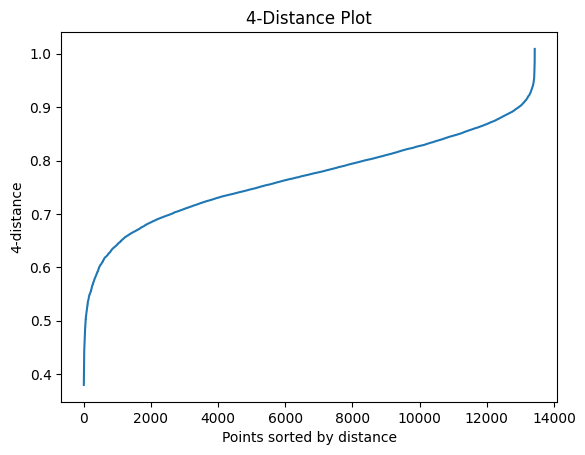

In [17]:
# Normalize the data (optional but recommended)
scaler = StandardScaler()
embedded_text_data_normalized = scaler.fit_transform(embedings)

# Compute the k-distance plot
k = 4  # min_samples - 1
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(embedings)
distances, indices = nbrs.kneighbors(embedings)

# Sort the distances and plot
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-distance')
plt.title(f'{k}-Distance Plot')
plt.show()

In [25]:
best_eps = None
best_score = -1

for eps in np.linspace(0.1, 40, 100):  # Adjust the range as needed
    dbscan = DBSCAN(eps=eps, min_samples=20)
    labels = dbscan.fit_predict(embedings)

    if len(set(labels)) > 1:  # Silhouette score requires at least two clusters
        score = silhouette_score(embedded_text_data_normalized, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f"Best eps: {best_eps}, Best Silhouette Score: {best_score}")

Best eps: 0.906060606060606, Best Silhouette Score: 0.021906176867900584


In [24]:

from collections import Counter


clustering = DBSCAN(eps=0.62,metric='cosine').fit(embedings)
clustering.labels_
# Get unique labels and their counts
label_counts = Counter(clustering.labels_)

# Convert to a list of tuples (label, count) and display
unique_labels = list(label_counts.items())
print(unique_labels)

[(np.int64(0), 13430)]


InvalidParameterError: The 'metric' parameter of DBSCAN must be a str among {'seuclidean', 'russellrao', 'mahalanobis', 'correlation', 'rogerstanimoto', 'sokalmichener', 'braycurtis', 'matching', 'manhattan', 'yule', 'jaccard', 'sokalsneath', 'sqeuclidean', 'cosine', 'chebyshev', 'wminkowski', 'haversine', 'minkowski', 'hamming', 'dice', 'nan_euclidean', 'canberra', 'cityblock', 'l1', 'precomputed', 'euclidean', 'l2'} or a callable. Got 'eulclidian' instead.